### Behavioral Engine - Email Clicks (Propensity Model)

This notebook is my first-pass attempt at creating a procedure for modeling email click behavior.<br>
Modeling open behavior is half of the ML needed for the prototype email personalization system, or "brain".<br>
This notebook is by-no-means a finalized modeling process, but should inform later versions.

#### Objective

Predict whether a user for a certain campaign, for a certain day, will click emails sent from REI. My data exploration for predictive features is not included in this notebook.

#### Methods

I will follow these high-level steps below:

1. Extract email data into several pandas dataframes
2. Transform data into featurized columns and handle null values
3. Remove highly correlated feature columns
4. Split into test and train sets
5. Hyperparameter tuning for feature selection models
6. Simple feature selection with RF or Logistic classifiers
7. "Final" model testing

#### Assumptions

- The engine will be needed for Ad_Hoc MARKETING_STRATEGY campaigns
- For purposes of testing the process generally, I will not distinguish between program types within Ad_Hoc, I am looking for generally-predictive features and behaviors
    - This will likely not be the case in implementation, data will be sliced/diced for a certain campaign type
- For purposes of simplified testing, I will confine my results to smaller lookback windows.  This means that temporal conditions and campaign schedules will certainly affect results and accuracy as well.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
#imports
import numpy as np
import pandas as pd
import pyodbc
from sql_mod2 import create_connection, create_df, run_sql, run_sql_one

#some data processing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#hyperparameter tuning libraries
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#a bunch of classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
#ensemble methods
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

#scaling methods
from sklearn import preprocessing
import datetime

#visualize
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

%matplotlib inline

#libraries to evaluate the models
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, f1_score, auc, roc_curve, roc_auc_score
from sklearn import metrics

#display results as HTML
from IPython.display import display, HTML

counter = 0

#### Data Extraction

Several queries becoming several dataframes, below.

In [19]:
#EXTRACT query

#potentially, get an id for each email sent, that ties across all tables

query2 = """

   SELECT RIID
        , EMAIL_ADDRESS
        , EMAIL_ISP
        , program
        , program_type
        
        -- MARKETING_PROGRAM
        , DATE_PART('dow', time_sent) dow_sent
        , DATE_PART('HOUR', time_sent) hour_sent
        , min(EVENT_CAPTURED_DATETIME) as event_captured_datetime
        , avg(date(time_sent) - date(prior_open_time))
        
        -- other prior actions
        , max(sent_prior) as sent_prior
        , max(fatigue_cnt) as fatigue_cnt
        , max(clicked_prior) as clicked_prior
        
        -- prior program flags
        , max(CASE WHEN prior_campaign_name LIKE '%_OUT_%' THEN 1 ELSE 0 END) as opened_outlet_prior
        , max(CASE WHEN prior_campaign_name LIKE '%_OFP_%' THEN 1 ELSE 0 END) as opened_off_price_prior
        , max(CASE WHEN prior_campaign_name LIKE '%StoreEvents%' THEN 1 ELSE 0 END) as opened_store_events_prior
        , max(CASE WHEN prior_campaign_name LIKE '%_ADM_%' THEN 1 ELSE 0 END) as opened_activity_prior
        , max(CASE WHEN prior_campaign_name LIKE '%_ADV_%' THEN 1 ELSE 0 END) as opened_adventure_travel_prior
        , max(CASE WHEN prior_campaign_name LIKE '%_FPM_%' THEN 1 ELSE 0 END) as opened_full_price_moment_prior
        , max(CASE WHEN prior_campaign_name LIKE '%_MEM_%' THEN 1 ELSE 0 END) as opened_membership_prior
        , max(CASE WHEN prior_campaign_name LIKE '%_OPO_%' THEN 1 ELSE 0 END) as opened_local_experiences_prior
        , max(CASE WHEN prior_campaign_name LIKE '%_STR_%' THEN 1 ELSE 0 END) as opened_stream_story_prior
        , max(CASE WHEN prior_campaign_name LIKE '%_TGR_%' THEN 1 ELSE 0 END) as opened_trigger_prior
        , max(CASE WHEN prior_campaign_name LIKE '%_VC_%' THEN 1 ELSE 0 END) as opened_vendor_collab_prior

        -- prior program_type flags
        , max(CASE WHEN prior_campaign_name LIKE '%Backpack%' THEN 1 ELSE 0 END) as prior_backpack
        , max(CASE WHEN prior_campaign_name LIKE '%Hike%' THEN 1 ELSE 0 END) as prior_hike
        , max(CASE WHEN prior_campaign_name LIKE '%Cycle%' THEN 1 ELSE 0 END) as prior_cycle
        , max(CASE WHEN prior_campaign_name LIKE '%Swim%' THEN 1 ELSE 0 END) as prior_swim
        , max(CASE WHEN prior_campaign_name LIKE '%Travel%' THEN 1 ELSE 0 END) as prior_travel
        , max(CASE WHEN prior_campaign_name LIKE '%Camp%' THEN 1 ELSE 0 END) as prior_camp
        , max(CASE WHEN prior_campaign_name LIKE '%Climb%' THEN 1 ELSE 0 END) as prior_climb
        , max(CASE WHEN prior_campaign_name LIKE '%Run%' THEN 1 ELSE 0 END) as prior_run
        , max(CASE WHEN prior_campaign_name LIKE '%Experiences%' THEN 1 ELSE 0 END) as prior_experiences
        , max(CASE WHEN prior_campaign_name LIKE '%Clearance%' THEN 1 ELSE 0 END) as prior_clearance
        , max(CASE WHEN prior_campaign_name LIKE '%Dividend%' THEN 1 ELSE 0 END) as prior_dividend
        , max(CASE WHEN prior_campaign_name LIKE '%Vote%' THEN 1 ELSE 0 END) as prior_vote
        , max(CASE WHEN prior_campaign_name LIKE '%OutdoorLife%' THEN 1 ELSE 0 END) as prior_outdoorlife
        , max(CASE WHEN prior_campaign_name LIKE '%TempMarks%' THEN 1 ELSE 0 END) as prior_tempmarks
        , max(CASE WHEN prior_campaign_name LIKE '%Newsletter%' THEN 1 ELSE 0 END) as prior_newsletter
        , max(CASE WHEN prior_campaign_name LIKE '%SaveMore%' THEN 1 ELSE 0 END) as prior_savemore
        , max(CASE WHEN prior_campaign_name LIKE '%Events%' 
            OR prior_campaign_name LIKE '%MemberHikeandJam%'
            OR prior_campaign_name LIKE '%FreeWeekend%' 
            THEN 1 ELSE 0 END) as prior_events
        , max(CASE WHEN prior_campaign_name LIKE '%MatchTheDividence%' THEN 1 ELSE 0 END) as prior_mtd
        , max(CASE WHEN prior_campaign_name LIKE '%Markdowns%' THEN 1 ELSE 0 END) as prior_markdowns
        , max(CASE WHEN prior_campaign_name LIKE '%Snow%' THEN 1 ELSE 0 END) as prior_snow
        , max(CASE WHEN prior_campaign_name LIKE '%Adventures%' THEN 1 ELSE 0 END) as prior_adventures

        -- general open prior features
        , max(opened_prior) as opened_prior
        , max(opened_prior_cnt) as opened_prior_cnt
        , max(open_target) as open_target
        , max(click_target) as click_target

    FROM (

       SELECT a.RIID
            , a.EMAIL_ISP
            , a.EVENT_CAPTURED_DATETIME
            , b.campaign_name
            , email.EMAIL_ADDRESS
            , CASE
                WHEN b.campaign_name LIKE '%_OUT_%' THEN 'outlet'
                WHEN b.campaign_name LIKE '%_OFP_%' THEN 'off_price'
                WHEN b.campaign_name LIKE '%StoreEvents%' THEN 'store_events'
                WHEN b.campaign_name LIKE '%_ADM_%' THEN 'activity'
                WHEN b.campaign_name LIKE '%_ADV_%' THEN 'adventure_travel'
                WHEN b.campaign_name LIKE '%_FPM_%' THEN 'full_price_moment'
                WHEN b.campaign_name LIKE '%_MEM_%' THEN 'membership'
                WHEN b.campaign_name LIKE '%_OPO_%' THEN 'local_experiences'
                WHEN b.campaign_name LIKE '%_STR_%' THEN 'steam_story'
                WHEN b.campaign_name LIKE '%_TGR_%' THEN 'trigger'
                WHEN b.campaign_name LIKE '%_VC_%' THEN 'vendor_collab'
                END as program

            , CASE 
                WHEN b.CAMPAIGN_NAME LIKE '%Backpack%' THEN 'backpack'
                WHEN b.CAMPAIGN_NAME LIKE '%Hike%' THEN 'hike'
                WHEN b.CAMPAIGN_NAME LIKE '%Cycle%' THEN 'cycle'
                WHEN b.CAMPAIGN_NAME LIKE '%Swim%' THEN 'water'
                WHEN b.CAMPAIGN_NAME LIKE '%Travel%' THEN 'travel'
                WHEN b.CAMPAIGN_NAME LIKE '%Camp%' THEN 'camp'
                WHEN b.CAMPAIGN_NAME LIKE '%Climb%' THEN 'climb'
                WHEN b.CAMPAIGN_NAME LIKE '%Run%' THEN 'run'
                WHEN b.CAMPAIGN_NAME LIKE '%Experiences%' THEN 'experiences'
                WHEN b.CAMPAIGN_NAME LIKE '%Clearance%' THEN 'clearance'
                WHEN b.CAMPAIGN_NAME LIKE '%Dividend%' THEN 'dividend'
                WHEN b.CAMPAIGN_NAME LIKE '%Vote%' THEN 'vote'
                WHEN b.CAMPAIGN_NAME LIKE '%OutdoorLife%' THEN 'outdoorlife'
                WHEN b.CAMPAIGN_NAME LIKE '%TempMarks%' THEN 'tempmarks'
                WHEN b.CAMPAIGN_NAME LIKE '%Newsletter%' THEN 'newsletter'
                WHEN b.CAMPAIGN_NAME LIKE '%SaveMore%' THEN 'savemore'
                WHEN b.CAMPAIGN_NAME LIKE '%Events%' 
                OR b.CAMPAIGN_NAME LIKE '%MemberHikeandJam%' 
                OR b.CAMPAIGN_NAME LIKE '%FreeWeekend%' THEN 'events'
                WHEN b.CAMPAIGN_NAME LIKE '%MatchTheDividend%' THEN 'mtd'
                WHEN b.CAMPAIGN_NAME LIKE '%LDS%' THEN 'lds'
                WHEN b.CAMPAIGN_NAME LIKE '%Markdowns%' THEN 'markdowns'
                WHEN b.CAMPAIGN_NAME LIKE '%10off50%' THEN '10off50'
                WHEN b.CAMPAIGN_NAME LIKE '%Snow%' THEN 'snow'
                WHEN b.CAMPAIGN_NAME LIKE '%Resend%' THEN 'resend'
                WHEN b.CAMPAIGN_NAME LIKE '%Adventures%' THEN 'adventures'
            END as program_type

            , a.EVENT_CAPTURED_DATETIME time_sent

            , CASE WHEN o.RIID IS NOT NULL 
                AND o.EVENT_CAPTURED_DATETIME < a.EVENT_CAPTURED_DATETIME 
                AND o.CAMPAIGN_ID <> a.CAMPAIGN_ID
                THEN o.EVENT_CAPTURED_DATETIME END as prior_open_time

            , CASE WHEN o.RIID IS NOT NULL 
                AND o.EVENT_CAPTURED_DATETIME < a.EVENT_CAPTURED_DATETIME 
                AND o.CAMPAIGN_ID <> a.CAMPAIGN_ID
                THEN o.campaign_name END as prior_campaign_name

            , max(
                CASE WHEN sp.RIID IS NOT NULL 
                THEN 1 ELSE 0 END
                ) as sent_prior -- needs to be split out

            , count(distinct sp.CM_SENT_KEY) as fatigue_cnt

             , max(
                CASE WHEN o.RIID IS NOT NULL 
                AND o.EVENT_CAPTURED_DATETIME < a.EVENT_CAPTURED_DATETIME 
                AND o.CAMPAIGN_ID <> a.CAMPAIGN_ID
                THEN 1 ELSE 0 END
                ) as opened_prior

            , count( distinct
                CASE WHEN o.RIID IS NOT NULL 
                AND o.EVENT_CAPTURED_DATETIME < a.EVENT_CAPTURED_DATETIME 
                AND o.CAMPAIGN_ID <> a.CAMPAIGN_ID
                THEN o.RIID||o.CM_OPEN_KEY END
                ) as opened_prior_cnt

            , max(
				CASE WHEN click.RIID IS NOT NULL 
				AND click.EVENT_CAPTURED_DATETIME < a.EVENT_CAPTURED_DATETIME
				AND click.CAMPAIGN_ID <> a.CAMPAIGN_ID
				THEN 1 ELSE 0 END
				) as clicked_prior

            -- target variables below
            , max(
                CASE WHEN o.RIID IS NOT NULL 
                AND o.EVENT_CAPTURED_DATETIME > a.EVENT_CAPTURED_DATETIME
                AND o.CAMPAIGN_ID = a.CAMPAIGN_ID
                THEN 1 ELSE 0 END
                ) as open_target

            , max(
                CASE WHEN click.RIID IS NOT NULL 
                AND click.EVENT_CAPTURED_DATETIME > a.EVENT_CAPTURED_DATETIME
                AND click.CAMPAIGN_ID = a.CAMPAIGN_ID
                THEN 1 ELSE 0 END
                ) as click_target

        FROM 
            ACTIVITY.ACTIVITY.CUSTOMER_MESSAGING_SENT a

        -- limit target data to 'Ad_Hoc' marketing strategies
        INNER JOIN 
            ACTIVITY.ACTIVITY.CM_CAMPAIGN_DIM b 
            ON b.CAMPAIGN_ID = a.CAMPAIGN_ID 
            AND b.MARKETING_STRATEGY = 'Ad_Hoc'
            AND b.CAMPAIGN_NAME LIKE '%_ADM_%'

        -- get target of OPEN and opens in last 9 days
        LEFT JOIN (
            SELECT o.RIID
                , o.EVENT_CAPTURED_DATETIME
                , o.CAMPAIGN_ID
                , o.CM_OPEN_KEY
                --, cam.MARKETING_PROGRAM
                , cam.campaign_name
            FROM ACTIVITY.ACTIVITY.CUSTOMER_MESSAGING_OPEN o
            INNER JOIN ACTIVITY.ACTIVITY.CM_CAMPAIGN_DIM cam 
                ON o.CAMPAIGN_ID = cam.CAMPAIGN_ID
                AND cam.MARKETING_STRATEGY <> 'TEST'
            AND o.EVENT_CAPTURED_DATETIME > current_date - 60
        ) o ON o.RIID = a.RIID

        -- try adding fatigue, like sent in the last 7 days before
        LEFT JOIN ACTIVITY.ACTIVITY.CUSTOMER_MESSAGING_SENT sp
            ON sp.RIID = a.RIID
            AND sp.CAMPAIGN_ID <> a.CAMPAIGN_ID
            AND SP.EVENT_CAPTURED_DATETIME < a.EVENT_CAPTURED_DATETIME
            AND sp.EVENT_CAPTURED_DATETIME > current_date - 60

        -- clicked in the last 40 days
        LEFT JOIN (

            SELECT click.RIID
                , click.EVENT_CAPTURED_DATETIME
                , click.CAMPAIGN_ID
            FROM ACTIVITY.ACTIVITY.CUSTOMER_MESSAGING_CLICK click
            WHERE click.EVENT_CAPTURED_DATETIME > current_date - 60

        ) click ON click.RIID = a.RIID

        -- add email addresses
        LEFT JOIN (
            SELECT RESPONSYS_INTERACT_ID as RIID
                , EMAIL_ADDR as email_address
            FROM PARTY.PARTY.EMAIL_DIM
        ) email ON email.RIID = a.RIID

        -- limit data to the last 2 days
        WHERE a.EVENT_CAPTURED_DATETIME > current_date - 30

        -- get rid of dupes
        GROUP BY 1,2,3,4,5,6,7,8,9,10

    ) a

    GROUP BY 1,2,3,4,5,6,7,time_sent

    ORDER BY RANDOM()
    LIMIT 500000


"""

#### First Dataframe - open behavior data

This first dataframe contains the target variable as well as previous email open behavior.

In [20]:
#put results into dataframe in pandas
import datetime 
import time

currentDT = datetime.datetime.now()
print ('Starting time:',currentDT.strftime("%I:%M %p"))
start_time = time.time()

df2 = create_df(query2,create_connection(dbn='SYSTEM'))
print(str(len(df2))+' rows')
print('')

#elapsed minutes
elapsed_time = round((time.time() - start_time)/60,1)
print(str(elapsed_time)+" minutes")

df2.head()

Starting time: 11:56 AM
connecting to db...connected...dataframe returned
500000 rows

15.3 minutes


,RIID,EMAIL_ADDRESS,EMAIL_ISP,PROGRAM,PROGRAM_TYPE,DOW_SENT,HOUR_SENT,EVENT_CAPTURED_DATETIME,AVG,SENT_PRIOR,...,PRIOR_SAVEMORE,PRIOR_EVENTS,PRIOR_MTD,PRIOR_MARKDOWNS,PRIOR_SNOW,PRIOR_ADVENTURES,OPENED_PRIOR,OPENED_PRIOR_CNT,OPEN_TARGET,CLICK_TARGET
0,337547815,JOSEPH.BALLEW@GMAIL.COM,gmail.com,activity,outdoorlife,1,8,2019-09-08 08:37:04,19.000000,1,...,0,1,0,0,0,0,1,1,0,0
1,54899024,HJUDD@ACCIONGROUP.COM,acciongroup.com,activity,outdoorlife,1,9,2019-09-08 09:49:04,26.650000,1,...,0,1,0,1,0,1,1,4,0,0
2,51219390,CLANDES@STORIES-TO-TELL.COM,stories-to-tell.com,activity,outdoorlife,1,8,2019-09-08 08:49:13,27.666667,1,...,0,0,0,0,0,0,1,2,0,1
3,146704355,NATALIE.ELIZA@GMAIL.COM,gmail.com,activity,outdoorlife,1,8,2019-09-08 08:43:04,NaN,1,...,0,0,0,0,0,0,0,0,0,0
4,72444235,HOLLYRECTENWALD@YAHOO.COM,yahoo.com,activity,cycle,2,3,2019-09-16 03:31:26,23.111111,1,...,1,1,0,1,0,1,1,2,1,0


In [21]:
#LOAD for later
df_target = df2
del df2
counter = counter+1
run = datetime.date.today().strftime("%Y%m%d")
run = run+'_'+str(counter)
df_target.to_csv('data/click_target_features'+run+'.csv',index=False)

In [22]:
run = datetime.date.today().strftime("%Y%m%d")
run = run+'_'+str(counter)
print(run)

20190924_2


In [23]:
df_target = pd.read_csv('data/click_target_features'+run+'.csv')

In [24]:
df_target.columns

Index(['RIID', 'EMAIL_ADDRESS', 'EMAIL_ISP', 'PROGRAM', 'PROGRAM_TYPE',
       'DOW_SENT', 'HOUR_SENT', 'EVENT_CAPTURED_DATETIME', 'AVG', 'SENT_PRIOR',
       'FATIGUE_CNT', 'CLICKED_PRIOR', 'OPENED_OUTLET_PRIOR',
       'OPENED_OFF_PRICE_PRIOR', 'OPENED_STORE_EVENTS_PRIOR',
       'OPENED_ACTIVITY_PRIOR', 'OPENED_ADVENTURE_TRAVEL_PRIOR',
       'OPENED_FULL_PRICE_MOMENT_PRIOR', 'OPENED_MEMBERSHIP_PRIOR',
       'OPENED_LOCAL_EXPERIENCES_PRIOR', 'OPENED_STREAM_STORY_PRIOR',
       'OPENED_TRIGGER_PRIOR', 'OPENED_VENDOR_COLLAB_PRIOR', 'PRIOR_BACKPACK',
       'PRIOR_HIKE', 'PRIOR_CYCLE', 'PRIOR_SWIM', 'PRIOR_TRAVEL', 'PRIOR_CAMP',
       'PRIOR_CLIMB', 'PRIOR_RUN', 'PRIOR_EXPERIENCES', 'PRIOR_CLEARANCE',
       'PRIOR_DIVIDEND', 'PRIOR_VOTE', 'PRIOR_OUTDOORLIFE', 'PRIOR_TEMPMARKS',
       'PRIOR_NEWSLETTER', 'PRIOR_SAVEMORE', 'PRIOR_EVENTS', 'PRIOR_MTD',
       'PRIOR_MARKDOWNS', 'PRIOR_SNOW', 'PRIOR_ADVENTURES', 'OPENED_PRIOR',
       'OPENED_PRIOR_CNT', 'OPEN_TARGET', 'CLICK_TARGET'],

In [ ]:
#clickstream query

query3 = """

with clickstream_users as (

    SELECT c1.CUST_KEY
        , -- add datetime for the click here
        , max(CASE WHEN c1.FIRST_MARKETING_PROGRAM LIKE '%Organic%' THEN 1 ELSE 0 END) as FIRST_ORGANIC_FLAG
        , max(CASE WHEN c1.FIRST_MARKETING_PROGRAM LIKE '%Direct Load%' THEN 1 ELSE 0 END) as FIRST_DIRECT_FLAG
        , max(CASE WHEN c1.FIRST_MARKETING_PROGRAM LIKE '%Email - Commercial%' THEN 1 ELSE 0 END) as FIRST_EMAIL_COMMERCIAL_FLAG
        , max(CASE WHEN c1.FIRST_MARKETING_PROGRAM LIKE '%PLA%' THEN 1 ELSE 0 END) as FIRST_PLA_FLAG
        , max(CASE WHEN c1.FIRST_MARKETING_PROGRAM LIKE '%Affiliates%' THEN 1 ELSE 0 END) as FIRST_AFF_FLAG
        , max(CASE WHEN c1.FIRST_MARKETING_PROGRAM LIKE '%Email - Non-Commercial%' THEN 1 ELSE 0 END) as FIRST_EMAIL_NC_FLAG
        , max(CASE WHEN c1.FIRST_MARKETING_PROGRAM LIKE '%Email - Transactional%' THEN 1 ELSE 0 END) as FIRST_EMAIL_T_FLAG
        , max(CASE WHEN c1.FIRST_MARKETING_PROGRAM LIKE '%Social%' THEN 1 ELSE 0 END) as FIRST_SOCIAL_FLAG
        , max(CASE WHEN c1.FIRST_MARKETING_PROGRAM LIKE '%Paid Search%' THEN 1 ELSE 0 END) as FIRST_PAID_SEARCH_FLAG
        , max(CASE WHEN c1.SESSION_CONTENT_TYPE LIKE '%Merch%' THEN 1 ELSE 0 END) as SESSION_CONTENT_MERCH_FLAG
        , max(CASE WHEN c1.SESSION_CONTENT_TYPE LIKE '%Experiences%' THEN 1 ELSE 0 END) as SESSION_CONTENT_EXPERIENCES_FLAG
        , max(CASE WHEN c1.SESSION_CONTENT_TYPE LIKE '%Learn%' THEN 1 ELSE 0 END) as SESSION_CONTENT_LEARN_FLAG
        , max(CASE WHEN c1.DEVICE_TYPE = 'DESKTOP' THEN 1 ELSE 0 END) as DESKTOP_FLAG
        , max(CASE WHEN c1.DEVICE_TYPE = 'MOBILE' THEN 1 ELSE 0 END) as MOBILE_FLAG
        , avg(c1.DERIVED_VISIT_NUM) avg_derived_visit_num
        , avg(SESSION_DURATION_IN_SECONDS) avg_session_duration
        , avg(CLICKS_COUNT) avg_clicks_count
        , avg(PAGE_VIEW_COUNT) avg_pv_cnt
        , avg(BOUNCE_FLAG) avg_bounce
    FROM CLICKSTREAM.CLICKSTREAM.SESSION_CUSTOMER c1
    WHERE c1.SESSION_START_DATETIME > current_date - 10
        AND CUST_KEY <> -2
    GROUP BY 1
    ORDER BY 1

)

SELECT c1.*
    , p.PRIMARY_EMAIL_ADDR as EMAIL_ADDRESS
FROM PARTY.PARTY.CUST_DIM p
INNER JOIN clickstream_users c1 ON c1.CUST_KEY = p.CUST_KEY

"""

#### Second Dataframe - clickstream data

This second dataframe looks at some sparse user clickstream behavior that is associated with email users.

In [ ]:
#put clickstream data into dataframe
df_clicks = sql_df().create_df(query3)
df_clicks.head()

Below, grouping clickstream data at the email level.

In [ ]:
#get 1 row per email
df_clicks = df_clicks.groupby('EMAIL_ADDRESS').agg({
    'FIRST_ORGANIC_FLAG':{'first_organic_flag':'max'},
    'FIRST_DIRECT_FLAG':{'first_direct_flag':'max'},
    'FIRST_EMAIL_COMMERCIAL_FLAG':{'first_emailc_flag':'max'},
    'FIRST_PLA_FLAG':{'first_pla_flag':'max'},
    'FIRST_AFF_FLAG':{'first_aff_flag':'max'},
    'FIRST_EMAIL_NC_FLAG':{'first_emailnc_flag':'max'},
    'FIRST_EMAIL_T_FLAG':{'first_emailt_flag':'max'},
    'FIRST_SOCIAL_FLAG':{'first_social_flag':'max'},
    'FIRST_PAID_SEARCH_FLAG':{'first_paid_flag':'max'},
    'SESSION_CONTENT_MERCH_FLAG':{'scm_flag':'max'},
    'SESSION_CONTENT_EXPERIENCES_FLAG':{'sce_flag':'max'},
    'SESSION_CONTENT_LEARN_FLAG':{'scl_flag':'max'},
    'DESKTOP_FLAG':{'desktop_flag':'max'},
    'MOBILE_FLAG':{'mobile_flag':'max'}
})

df_clicks.columns = df_clicks.columns.droplevel()

In [ ]:
#LOAD for later
df_clicks.to_csv('data/open_clickstream_features'+run+'.csv',index=False)

In [ ]:
#purchase data

query4 = """

SELECT a.RIID
    , CASE WHEN ee.primary_email_addr IS NOT NULL THEN 1 ELSE 0 END as order_flag
    , CASE WHEN ee.ONLINE_ORDER_CNT IS NOT NULL AND ee.ONLINE_ORDER_CNT > 0 THEN 1 ELSE 0 END as online_order_flag
    , ee.online_order_cnt
    , ee.online_tot_spend
    , ee.last_online_order_datetime
    , ee.offline_order_cnt
    , ee.offline_tot_spend
FROM 
    ACTIVITY.ACTIVITY.CUSTOMER_MESSAGING_SENT a

-- limit target data to 'Ad_Hoc' marketing strategies
INNER JOIN 
    ACTIVITY.ACTIVITY.CM_CAMPAIGN_DIM b 
    ON b.CAMPAIGN_ID = a.CAMPAIGN_ID 
    AND b.MARKETING_STRATEGY = 'Ad_Hoc'

LEFT JOIN (

    SELECT e.RESPONSYS_INTERACT_ID as RIID
        , e.EMAIL_ADDR as email_address
    FROM PARTY.PARTY.EMAIL_DIM e

) e ON e.RIID = a.RIID

-- customer order behavioral profile
-- will need to use the same data to look at product types, etc
LEFT JOIN (

    SELECT cd.PRIMARY_EMAIL_ADDR 
        --, ci.ORDER_CUST_TYPE_DESC
        --, ci.PRODUCT_NAME
        --, ci.SHOP_DESC
        --, ci.DEPARTMENT_DESC
        --, ci.CLASS_DESC
        --, ci.SUBCLASS_DESC
        --, ci.BRAND_DESC
        --, ci.AGE_GENERATION_SEGMENT
        --, ci.GENDER_DESC
        --, ci.EDUCATION_LEVEL_DESC -- seeing multiple of these for 1 email, argh
        , max(distinct CASE WHEN ci.ORDER_SALES_CHANNEL_DESC = 'Online' THEN ORDER_DATETIME END) last_online_order_datetime
        , max(CASE WHEN ORDER_CUST_TYPE_DESC = 'Member' THEN 1 ELSE 0 END) as member_flag
        , count(distinct CASE WHEN ci.ORDER_SALES_CHANNEL_DESC = 'Online' THEN ORDER_DATETIME END) as ONLINE_ORDER_CNT
        , sum(CASE WHEN ci.ORDER_SALES_CHANNEL_DESC = 'Online' THEN ci.ORDER_AMT END) as ONLINE_TOT_SPEND
        , count(distinct CASE WHEN ci.ORDER_SALES_CHANNEL_DESC <> 'Online' THEN ORDER_DATETIME END) as OFFLINE_ORDER_CNT
        , sum(CASE WHEN ci.ORDER_SALES_CHANNEL_DESC <> 'Online' THEN ci.ORDER_AMT END) as OFFLINE_TOT_SPEND
    FROM PARTY.PARTY.CUST_DIM cd 
    INNER JOIN PARTY.PARTY.CUSTOMER_ITEM ci 
        ON ci.CUST_KEY = cd.CUST_KEY
        AND ci.ORDER_DATETIME > current_date - 90
	WHERE PRIMARY_EMAIL_ADDR IS NOT NULL
    GROUP BY 1

) ee ON ee.PRIMARY_EMAIL_ADDR = e.EMAIL_ADDRESS

"""

#### Third dataframe - member order data

This dataframe pulls in some sparse-and-simple data re: member purchase activity.

In [ ]:
#put purchase data into dataframe
df_purchase = sql_df().create_df(query4)
df_purchase = df_purchase.fillna(0)
df_purchase.head()

In [4]:
#group the purchase rows at the RIID level
df_purchase = df_purchase.astype('float64')

df_purchase_ = df_purchase[df_purchase['ONLINE_TOT_SPEND'] >= 0 ].groupby('RIID').agg({
    'ORDER_FLAG':{'order_flag':'max'},
    'ONLINE_ORDER_FLAG':{'online_order_flag':'max'},
    'ONLINE_ORDER_CNT':{'online_order_cnt':'sum'},
    'ONLINE_TOT_SPEND':{'oneline_tot_spend':'sum'},
    'OFFLINE_ORDER_CNT':{'offline_order_cnt':'sum'},
    'OFFLINE_TOT_SPEND':{'offline_tot_spend':'sum'}
})

df_purchase_.columns = df_purchase_.columns.droplevel()

df_purchase_.reset_index(inplace=True)

C:\Users\taynels\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\groupby\generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [ ]:
#LOAD for later
df_purchase_.to_csv('data/open_purchase_features'+run+'.csv',index=False)

In [ ]:
#customer profile query 
profile_query = """

    SELECT PRIMARY_EMAIL_ADDR as EMAIL_ADDRESS
        , max(CASE WHEN CUST_STATUS_DESC = 'Active' Then 1 ELSE 0 END) as active_flag
        , max(CASE WHEN CUST_TYPE_DESC = 'CSA_Member' Then 1 else 0 END) as csa_member_flag
    FROM PARTY..CUST_DIM -- CUSTOMER_PROFILE
    WHERE --M_UPDATE_DATETIME > current_date - 350
        --AND 
        PRIMARY_EMAIL_ADDR IS NOT NULL
        AND PRIMARY_EMAIL_ADDR <> ''
    GROUP BY 1

"""

#### Fourth Dataframe - simple member data

This dataframe pulls very-simple membership profile data for the last year.  Simple flags a member.

In [ ]:
#put profile data into dataframe
df_profile = sql_df().create_df(profile_query)
df_profile.head()

In [ ]:
#LOAD for later
df_profile.to_csv('data/open_profile_features'+run+'.csv',index=False)

In [3]:
#pull dataframes from flat files
df2 = pd.read_csv('data/open_propensity_more_prior_open_features0823_1.csv')
df_clicks = pd.read_csv('data/open_propensity_clickstream_features0823_1.csv')
df_purchase = pd.read_csv('data/open_propensity_purchase_features0823_1.csv')
df_profile = pd.read_csv('data/profile_features0826_1.csv')

In [5]:
#merge the dataframes
df2 = pd.merge(df2, df_clicks, how='left', on='EMAIL_ADDRESS')
df2 = pd.merge(df2,df_purchase_, how='left', on='RIID')
df2 = pd.merge(df2,df_profile, how='left', on='EMAIL_ADDRESS')

In [6]:
del df_clicks
del df_purchase_
del df_profile

In [25]:
df_target.head()

,RIID,EMAIL_ADDRESS,EMAIL_ISP,PROGRAM,PROGRAM_TYPE,DOW_SENT,HOUR_SENT,EVENT_CAPTURED_DATETIME,AVG,SENT_PRIOR,...,PRIOR_SAVEMORE,PRIOR_EVENTS,PRIOR_MTD,PRIOR_MARKDOWNS,PRIOR_SNOW,PRIOR_ADVENTURES,OPENED_PRIOR,OPENED_PRIOR_CNT,OPEN_TARGET,CLICK_TARGET
0,337547815,JOSEPH.BALLEW@GMAIL.COM,gmail.com,activity,outdoorlife,1,8,2019-09-08 08:37:04,19.000000,1,...,0,1,0,0,0,0,1,1,0,0
1,54899024,HJUDD@ACCIONGROUP.COM,acciongroup.com,activity,outdoorlife,1,9,2019-09-08 09:49:04,26.650000,1,...,0,1,0,1,0,1,1,4,0,0
2,51219390,CLANDES@STORIES-TO-TELL.COM,stories-to-tell.com,activity,outdoorlife,1,8,2019-09-08 08:49:13,27.666667,1,...,0,0,0,0,0,0,1,2,0,1
3,146704355,NATALIE.ELIZA@GMAIL.COM,gmail.com,activity,outdoorlife,1,8,2019-09-08 08:43:04,NaN,1,...,0,0,0,0,0,0,0,0,0,0
4,72444235,HOLLYRECTENWALD@YAHOO.COM,yahoo.com,activity,cycle,2,3,2019-09-16 03:31:26,23.111111,1,...,1,1,0,1,0,1,1,2,1,0


In [26]:
#TRANSFORMATIONS

#transform ISPs into one-hots

#check for these values
vals = ['gmail.com','yahoo.com','hotmail.com','aol.com','comcast.net'
        ,'msn.com','sbcglobal.net','me.com','mac.com','verizon.net'
        ,'icloud.com','att.net','live.com','cox.net']

for val in vals:
    
    def one_hot_val(x):
        if str(x) == val:
            return 1
        else:
            return 0    
        
    df_target[str(val)+'_isp'] = df_target['EMAIL_ISP'].apply(one_hot_val)

#need a bucket for all other values
def one_hot_notlist(x):
    if str(x) not in ['gmail.com','yahoo.com']:
        return 1
    else:
        return 0
    
df_target['OTHER_isp'] = df_target['EMAIL_ISP'].apply(one_hot_notlist)

In [28]:
#marketing program as a feature...
#program_dummies = pd.get_dummies(df2['MARKETING_PROGRAM'], prefix='program')
#df2 = pd.concat([df2,program_dummies],axis=1)

#try DOW as a feature
dow_dummies = pd.get_dummies(df_target['DOW_SENT'],prefix='dow')
df_target = pd.concat([df_target,dow_dummies],axis=1)

#df2['dow_wknd'] = df2['dow_6']+df2['dow_7']
#df2['dow_wkdy'] = 1
#df2['dow_wkdy'] = df2['dow_wkdy'] = df2['dow_wknd'] 

#try hour of day as a feature
hour_dummies = pd.get_dummies(df_target['HOUR_SENT'],prefix='hour')
df_target = pd.concat([df_target,hour_dummies],axis=1)

#program dummy
program_dummies = pd.get_dummies(df_target['PROGRAM'],prefix='program')
df_target = pd.concat([df_target,program_dummies],axis=1)
program_type_dummies = pd.get_dummies(df_target['PROGRAM_TYPE'],prefix='program_type')
df_target = pd.concat([df_target,program_type_dummies],axis=1)

#active flag

In [29]:
#check for blanks
print("No. of missing values in column are:")
names = df_target.columns.values
for i in range(1,len(df_target.columns)):
    col_is_null=df_target.iloc[:,i].isnull().sum()
    print(names[i],":",col_is_null)

No. of missing values in column are:
EMAIL_ADDRESS : 138
EMAIL_ISP : 0
PROGRAM : 0
PROGRAM_TYPE : 0
DOW_SENT : 0
HOUR_SENT : 0
EVENT_CAPTURED_DATETIME : 0
AVG : 153041
SENT_PRIOR : 0
FATIGUE_CNT : 0
CLICKED_PRIOR : 0
OPENED_OUTLET_PRIOR : 0
OPENED_OFF_PRICE_PRIOR : 0
OPENED_STORE_EVENTS_PRIOR : 0
OPENED_ACTIVITY_PRIOR : 0
OPENED_ADVENTURE_TRAVEL_PRIOR : 0
OPENED_FULL_PRICE_MOMENT_PRIOR : 0
OPENED_MEMBERSHIP_PRIOR : 0
OPENED_LOCAL_EXPERIENCES_PRIOR : 0
OPENED_STREAM_STORY_PRIOR : 0
OPENED_TRIGGER_PRIOR : 0
OPENED_VENDOR_COLLAB_PRIOR : 0
PRIOR_BACKPACK : 0
PRIOR_HIKE : 0
PRIOR_CYCLE : 0
PRIOR_SWIM : 0
PRIOR_TRAVEL : 0
PRIOR_CAMP : 0
PRIOR_CLIMB : 0
PRIOR_RUN : 0
PRIOR_EXPERIENCES : 0
PRIOR_CLEARANCE : 0
PRIOR_DIVIDEND : 0
PRIOR_VOTE : 0
PRIOR_OUTDOORLIFE : 0
PRIOR_TEMPMARKS : 0
PRIOR_NEWSLETTER : 0
PRIOR_SAVEMORE : 0
PRIOR_EVENTS : 0
PRIOR_MTD : 0
PRIOR_MARKDOWNS : 0
PRIOR_SNOW : 0
PRIOR_ADVENTURES : 0
OPENED_PRIOR : 0
OPENED_PRIOR_CNT : 0
OPEN_TARGET : 0
CLICK_TARGET : 0
gmail.com_isp :

In [31]:
#dice into independent and dependent variables
#select from 

X = df_target[[
'DOW_SENT',
 'HOUR_SENT',
 'AVG',
 'SENT_PRIOR',
 'FATIGUE_CNT',
 'OPENED_OUTLET_PRIOR',
 'OPENED_OFF_PRICE_PRIOR',
 'OPENED_STORE_EVENTS_PRIOR',
 'OPENED_ACTIVITY_PRIOR',
 'OPENED_ADVENTURE_TRAVEL_PRIOR',
 'OPENED_FULL_PRICE_MOMENT_PRIOR',
 'OPENED_MEMBERSHIP_PRIOR',
 'OPENED_LOCAL_EXPERIENCES_PRIOR',
 'OPENED_STREAM_STORY_PRIOR',
 'OPENED_TRIGGER_PRIOR',
 'OPENED_VENDOR_COLLAB_PRIOR',
 'PRIOR_BACKPACK',
 'PRIOR_HIKE',
 'PRIOR_CYCLE',
 'PRIOR_SWIM',
 'PRIOR_TRAVEL',
 'PRIOR_CAMP',
 'PRIOR_CLIMB',
 'PRIOR_RUN',
 'PRIOR_EXPERIENCES',
 'PRIOR_CLEARANCE',
 'PRIOR_DIVIDEND',
 'PRIOR_VOTE',
 'PRIOR_OUTDOORLIFE',
 'PRIOR_TEMPMARKS',
 'PRIOR_NEWSLETTER',
 'PRIOR_SAVEMORE',
 'PRIOR_EVENTS',
 'PRIOR_MTD',
 'PRIOR_MARKDOWNS',
 'PRIOR_SNOW',
 'PRIOR_ADVENTURES',
 'OPENED_PRIOR',
 'OPENED_PRIOR_CNT',
 'gmail.com_isp',
 'yahoo.com_isp',
 'hotmail.com_isp',
 'aol.com_isp',
 'comcast.net_isp',
 'msn.com_isp',
 'sbcglobal.net_isp',
 'me.com_isp',
 'mac.com_isp',
 'verizon.net_isp',
 'icloud.com_isp',
 'att.net_isp',
 'live.com_isp',
 'cox.net_isp',
 'OTHER_isp',
 'dow_1',
 'dow_2',
 'hour_3',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'program_activity',
 'program_type_cycle',
 'program_type_outdoorlife']]

y = df_target['CLICK_TARGET']

In [32]:
X.head()

,DOW_SENT,HOUR_SENT,AVG,SENT_PRIOR,FATIGUE_CNT,OPENED_OUTLET_PRIOR,OPENED_OFF_PRICE_PRIOR,OPENED_STORE_EVENTS_PRIOR,OPENED_ACTIVITY_PRIOR,OPENED_ADVENTURE_TRAVEL_PRIOR,...,hour_3,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,program_activity,program_type_cycle,program_type_outdoorlife
0,1,8,19.000000,1,23,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,1
1,1,9,26.650000,1,29,1,1,1,1,1,...,0,0,0,1,0,0,0,1,0,1
2,1,8,27.666667,1,41,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,1
3,1,8,NaN,1,30,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
4,2,3,23.111111,1,41,1,1,1,1,1,...,1,0,0,0,0,0,0,1,1,0


In [33]:
X.columns

Index(['DOW_SENT', 'HOUR_SENT', 'AVG', 'SENT_PRIOR', 'FATIGUE_CNT',
       'OPENED_OUTLET_PRIOR', 'OPENED_OFF_PRICE_PRIOR',
       'OPENED_STORE_EVENTS_PRIOR', 'OPENED_ACTIVITY_PRIOR',
       'OPENED_ADVENTURE_TRAVEL_PRIOR', 'OPENED_FULL_PRICE_MOMENT_PRIOR',
       'OPENED_MEMBERSHIP_PRIOR', 'OPENED_LOCAL_EXPERIENCES_PRIOR',
       'OPENED_STREAM_STORY_PRIOR', 'OPENED_TRIGGER_PRIOR',
       'OPENED_VENDOR_COLLAB_PRIOR', 'PRIOR_BACKPACK', 'PRIOR_HIKE',
       'PRIOR_CYCLE', 'PRIOR_SWIM', 'PRIOR_TRAVEL', 'PRIOR_CAMP',
       'PRIOR_CLIMB', 'PRIOR_RUN', 'PRIOR_EXPERIENCES', 'PRIOR_CLEARANCE',
       'PRIOR_DIVIDEND', 'PRIOR_VOTE', 'PRIOR_OUTDOORLIFE', 'PRIOR_TEMPMARKS',
       'PRIOR_NEWSLETTER', 'PRIOR_SAVEMORE', 'PRIOR_EVENTS', 'PRIOR_MTD',
       'PRIOR_MARKDOWNS', 'PRIOR_SNOW', 'PRIOR_ADVENTURES', 'OPENED_PRIOR',
       'OPENED_PRIOR_CNT', 'gmail.com_isp', 'yahoo.com_isp', 'hotmail.com_isp',
       'aol.com_isp', 'comcast.net_isp', 'msn.com_isp', 'sbcglobal.net_isp',
       'me.com_is

In [34]:
#add a few interactions
#X['outlet_outlet'] = np.multiply(np.array(X['OPENED_OUTLET_PRIOR']),np.array(X['campaign_outlet']))
#X['ofp_ofp'] = np.multiply(np.array(X['OPENED_OFF_PRICE_PRIOR']),np.array(X['campaign_off_price']))

In [35]:
X.head()

,DOW_SENT,HOUR_SENT,AVG,SENT_PRIOR,FATIGUE_CNT,OPENED_OUTLET_PRIOR,OPENED_OFF_PRICE_PRIOR,OPENED_STORE_EVENTS_PRIOR,OPENED_ACTIVITY_PRIOR,OPENED_ADVENTURE_TRAVEL_PRIOR,...,hour_3,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,program_activity,program_type_cycle,program_type_outdoorlife
0,1,8,19.000000,1,23,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,1
1,1,9,26.650000,1,29,1,1,1,1,1,...,0,0,0,1,0,0,0,1,0,1
2,1,8,27.666667,1,41,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,1
3,1,8,NaN,1,30,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
4,2,3,23.111111,1,41,1,1,1,1,1,...,1,0,0,0,0,0,0,1,1,0


In [36]:
#bin some numeric features by five quantiles
def quantize(col,X):

    X[col+'1'] = np.where(X[col] < X[col].quantile(.2),1,0)
    X[col+'2'] = np.where((X[col] >= X[col].quantile(.2)) & (X[col] < X[col].quantile(.4)),1,0)
    X[col+'3'] = np.where((X[col] >= X[col].quantile(.4)) & (X[col] < X[col].quantile(.6)),1,0)
    X[col+'4'] = np.where((X[col] >= X[col].quantile(.6)) & (X[col] < X[col].quantile(.8)),1,0)
    X[col+'5'] = np.where(X[col] >= X[col].quantile(.8),1,0)

    
#bin avg
quantize('AVG',X)
X = X.drop('AVG',axis=1)

#bin fatigue
quantize('FATIGUE_CNT',X)
X = X.drop('FATIGUE_CNT',axis=1)

#bin hour
quantize('HOUR_SENT',X)

#open prior dummies?

#

C:\Users\taynels\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\taynels\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\taynels\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [37]:
#add some more transforms
# X['online_prop'] = X['online_order_cnt']/X['offline_order_cnt']
# X['online_prop'] = X['online_prop'].replace(np.Inf, 1).astype('float_')
# X['online_prop'] = X['online_prop'].fillna(0.0)

In [38]:
#fillnans
#need to impute this better
X = X.fillna(-2)

#### Optional variance-thresholding code commented out below

In [39]:
# #drop features with super low variance
# from sklearn.feature_selection import VarianceThreshold

# threshold = 1
# selector=VarianceThreshold(threshold)
# selector.fit(X)

# discard_cols = []
# for col_num in range(len(X.columns)):
#     if (selector.variances_[col_num]) < 0.1:
#         discard_cols.append(X.columns[col_num])
        
# #drop low-variance volumns
# X.drop(discard_cols,axis=1)

#### Reduce highly-correlated columns

In [40]:
#check for high correlation
pred_corr_matrix = X.corr().abs()

#get initial column count
col_cnt = len(X.columns)

# Select upper triangle of correlation matrix
upper = pred_corr_matrix.where(np.triu(np.ones(pred_corr_matrix.shape), k=1).astype(np.bool))

#find columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print('Columns dropped:')
print(to_drop)

# Drop features above our correlation threshold
X = X.drop(X[to_drop], axis=1)

#show how many columns were dropped 
print(str(col_cnt-len(X.columns))+' columns dropped due to high correlation')

Columns dropped:
['PRIOR_EVENTS', 'PRIOR_ADVENTURES', 'dow_1', 'dow_2', 'program_type_cycle', 'program_type_outdoorlife', 'HOUR_SENT1', 'HOUR_SENT2', 'HOUR_SENT3', 'HOUR_SENT5']
10 columns dropped due to high correlation


#### Optional minmax scaling code commented out below

In [41]:
# #standardize the features between 1 and 0, good for logistic
# min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True)

# for col in X.columns:
#     X[col] = min_max_scaler.fit_transform(np.array(X[col]).reshape(-1, 1))

#### Split into test and train sets

In [42]:
#create test, train splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#reshape y_train
c = y_train.shape
y_train = y_train.values.reshape(c,)

#### Tune hyperparams

In [48]:
#tune hyperparams for a good random forest

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

#models
classifiers = [
    DecisionTreeClassifier(random_state=42,class_weight={0:2,1:4}), #should try different class weights
    RandomForestClassifier(random_state=42,n_jobs=3,class_weight='balanced'), #should try different class weights
]
            
#tuning params
tuning_params = [
    #DecisionTree params
    {"criterion":['gini','entropy'],
     "max_depth":[10,30,50,80,None],
    "max_features":[5,10,20,None]},
    #randomforest params
    {"n_estimators":[5,10,25,50,80,100,125],
    "criterion":["gini","entropy"],
    "max_depth":[10,30,50,None],
    "max_features":[5,10,15,None,"auto","sqrt","log2"],
    "class_weight":[{0:1,1:14}
                    , {0:1,1:16}
                    , {0:1,1:20}
                    ,'balanced']}     
]

#best classifiers
best_classifiers = []

#perform random_search here
for x in range(len(tuning_params)):
    
    n_iter_search = 10    
    random_search = RandomizedSearchCV(classifiers[x], param_distributions=tuning_params[x],
                                           n_iter=n_iter_search, cv=5, iid=False, n_jobs=3)
    random_search.fit(X_train, y_train)

    #report results
    print(random_search.best_estimator_)
    best_classifiers.append(random_search.best_estimator_)

DecisionTreeClassifier(class_weight={0: 2, 1: 4}, criterion='gini',
                       max_depth=10, max_features=20, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')
RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 14},
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=125, n_jobs=3, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)


In [49]:
#roc_curve function takes predicted labels as 'y_test', then true 'labels', then a title as arguments
#need to rename these arguments
def get_roc_curve(y_test,labels,title=''):

    fpr, tpr, _ = metrics.roc_curve(y_test, labels)    

    #calculate AUC
    roc_auc = metrics.auc(fpr,tpr)    
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title+'ROC')
    plt.legend(loc="lower right")
    plt.show()

In [50]:
#class imbalance is definitely a factor
Cs = np.logspace(-1,2,10)
#models to test
try:
    best_classifiers
    models = best_classifiers
except:
    models      =  [DecisionTreeClassifier(criterion='entropy',class_weight='balanced')
              , RandomForestClassifier(n_jobs=3, max_features=5
                                       ,class_weight={0:1,1:6}, criterion='entropy')]

### Find best features according to RF



DecisionTreeClassifier(class_weight={0: 2, 1: 4}, criterion='gini',
                       max_depth=10, max_features=20, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')


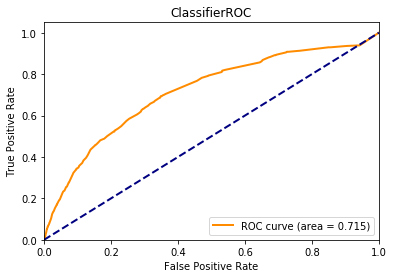

prediction threshold is: 0.2


,predicted not open,predicted open
not open,148162,447
open,1371,20


PRIOR_SAVEMORE,0.131534
PRIOR_MARKDOWNS,0.091129
OPENED_PRIOR_CNT,0.042599
HOUR_SENT,0.03859
gmail.com_isp,0.028898
OPENED_ADVENTURE_TRAVEL_PRIOR,0.027819
hour_3,0.024674
OPENED_STORE_EVENTS_PRIOR,0.024313
OPENED_FULL_PRICE_MOMENT_PRIOR,0.023982
PRIOR_DIVIDEND,0.023968
PRIOR_HIKE,0.023815




RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 14},
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=125, n_jobs=3, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)


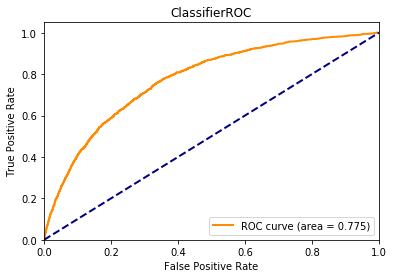

prediction threshold is: 0.2


,predicted not open,predicted open
not open,133143,15466
open,811,580


OPENED_OFF_PRICE_PRIOR,0.064015
FATIGUE_CNT5,0.063607
OPENED_PRIOR_CNT,0.063282
PRIOR_MARKDOWNS,0.062538
PRIOR_OUTDOORLIFE,0.05574
OPENED_OUTLET_PRIOR,0.046683
OPENED_STREAM_STORY_PRIOR,0.044451
OPENED_MEMBERSHIP_PRIOR,0.035388
OPENED_PRIOR,0.032039
PRIOR_SAVEMORE,0.030895
PRIOR_TEMPMARKS,0.030489


In [54]:
#fit the estimator and then predict
from IPython.display import HTML, display
import tabulate

log_scores = []
rf_scores = []
best_features = {}

for b in models:
    
    print("\n")
    print(b)
    
    #fit the estimator
    b.fit(X_train,y_train)    

    #make predictions
    predictions1 = b.predict(X_test) #used to be straight predictions, predict_proba?
    predictions_proba = b.predict_proba(X_test) #take only the first value
    predictions2 = [x[1] for x in predictions_proba]
    display(HTML('<h3>'+' ROC Curve</h3>'))

    if 'Logistic' in str(b):
        log_scores = predictions2
        
    if 'Random' in str(b):
        rf_scores = predictions2
    
    def styler(val):
        if val == 0:
            return 'color: red'
        else:
            return 'color: black; background-color: rgba(124,252,0,0.5); font-weight: bold'

    #print out ROC
    get_roc_curve(y_test,predictions2,title='Classifier')

    pred_thresh = 0.2
    predictions3 = predictions1
    predictions3 = [1 if y >= pred_thresh else 0 for y in predictions2]
    
    print('prediction threshold is: '+str(pred_thresh))
    
    #log-loss
    display(HTML('<p>log-loss: '+str(round(metrics.log_loss(y_test,predictions_proba),5))+'</p>'))

    #accuracy
    display(HTML('<p>accuracy: '+str(int(metrics.accuracy_score(y_test,predictions3)*100))+'%</p>'))
    
    #print out confusion matrix
    new_df = pd.DataFrame(metrics.confusion_matrix(y_test,predictions3))
    
    #print out precision and recall, since they relate to the true positive rate in a good way for emails
    
    #print out the f1 score, since it relates to the true positive rate in a good way for emails too
    #if f1 score is high, this means we may be in business, able to send a curated list that is more likely to lift
    display(HTML('<p>f1 score: '+str(round(metrics.f1_score(y_test, predictions3),5))+'</p>'))

    #print out recall
    display(HTML('<p>recall score: '+str(int(metrics.recall_score(y_test, predictions3)*100))+'%</p>'))
    
    #print out precision
    display(HTML('<p>precision score: '+str(int(metrics.precision_score(y_test, predictions3)*100))+'%</p>'))    
    
    #change column and index names
    new_df = new_df.rename(index=str, columns={1: "predicted open", 0: "predicted not open"})
    new_df = new_df.rename({'0': "not open", '1': "open"}, axis='index')

    #print out the results
    display(HTML('<h3>'+'Classifier'+' Confusion Matrix</h3>'))
    display(new_df.style.applymap(styler))
    print("\n")
    
    table = {}
    
    #examine components of the model
    if hasattr(b, 'feature_importances_'):
        #print(X.columns,b.feature_importances_)
        for x in range(len(X.columns)):
            table[X.columns[x]] = round(b.feature_importances_[x],6)
 
        #display feature importances
        table1 = sorted(table.items(), key=lambda kv: kv[1], reverse = True)
        display(HTML(tabulate.tabulate(table1, tablefmt='html')))
        
    elif hasattr(b,'coef_'):
        for x in range(len(X.columns)):
            table[X.columns[x]] = b.coef_[0][x]

        #display feature importances
        table2 = sorted(table.items(), key=lambda kv: kv[1], reverse = True)    
        display(HTML(tabulate.tabulate(table2, tablefmt='html')))

In [55]:
best_rf = b
best_rf

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 14},
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=125, n_jobs=3, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [57]:
#reduce dimensionality and pick the best features
best_features = table1
best_features_ = []
for i in range(len(best_features)):
    best_features_.append(best_features[i][0])

In [58]:
best_features_ = best_features_[:20] #take top 20 features, this could be optimize

### Try best features on LogisticCV

Generating final model...



['OPENED_STREAM_STORY_PRIOR', 'OPENED_OFF_PRICE_PRIOR', 'OPENED_OUTLET_PRIOR', 'OPENED_ADVENTURE_TRAVEL_PRIOR', 'PRIOR_OUTDOORLIFE', 'OPENED_ACTIVITY_PRIOR', 'OPENED_PRIOR_CNT', 'PRIOR_TRAVEL', 'PRIOR_MARKDOWNS', 'PRIOR_RUN', 'HOUR_SENT', 'PRIOR_HIKE', 'PRIOR_DIVIDEND', 'OPENED_FULL_PRICE_MOMENT_PRIOR', 'OPENED_STORE_EVENTS_PRIOR', 'OPENED_MEMBERSHIP_PRIOR', 'OPENED_PRIOR', 'PRIOR_CAMP', 'PRIOR_TEMPMARKS', 'DOW_SENT']


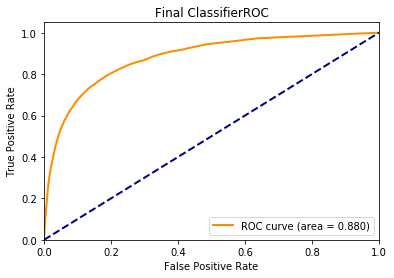

prediction threshold is: 0.6


,predicted not open,predicted open
not open,107545,16573
open,6962,18920


In [59]:
#train a new model, after feature selection using the best features from the random forest
print('Generating final model...\n')


zed = 20

# for zed in range(1,len(best_features_)):

display(HTML("<h2>Best Features: </h2><br>"))
print(best_features_)

#fit the model
clf = LogisticRegressionCV(Cs,cv=5,class_weight='balanced',max_iter=1000,n_jobs=3)
clf.fit(X_train[best_features_],y_train) 

#make predictions
predictions_proba = clf.predict_proba(X_test[best_features_]) #take only the first value
predictions2 = [x[1] for x in predictions_proba]
display(HTML('<h2>'+' ROC Curve</h2>'))

def styler(val):
    if val == 0:
        return 'color: red'
    else:
        return 'color: black; /*background-color: rgba(124,252,0,0.5);*/ font-weight: bold'

#print out ROC
get_roc_curve(y_test,predictions2,title='Final Classifier')

pred_thresh = 0.6
predictions3 = predictions1
predictions3 = [1 if y >= pred_thresh else 0 for y in predictions2]

#print out threshold
print('prediction threshold is: '+str(pred_thresh))

#log-loss
display(HTML('<p>log-loss: '+str(round(metrics.log_loss(y_test,predictions_proba),5))+'</p>'))

#accuracy
display(HTML('<p>accuracy: '+str(int(metrics.accuracy_score(y_test,predictions3)*100))+'%</p>'))

#print out confusion matrix
new_df = pd.DataFrame(metrics.confusion_matrix(y_test,predictions3))

#print out precision and recall, since they relate to the true positive rate in a good way for emails

#print out the f1 score, since it relates to the true positive rate in a good way for emails too
#if f1 score is high, this means we may be in business, able to send a curated list that is more likely to lift
display(HTML('<p>f1 score: '+str(round(metrics.f1_score(y_test, predictions3),2))+'</p>'))

#print out recall
display(HTML('<p>recall score: '+str(int(metrics.recall_score(y_test, predictions3)*100))+'%</p>'))

#print out precision
display(HTML('<p>precision score: '+str(int(metrics.precision_score(y_test, predictions3)*100))+'%</p>'))    

#change column and index names
new_df = new_df.rename(index=str, columns={1: "predicted open", 0: "predicted not open"})
new_df = new_df.rename({'0': "not open", '1': "open"}, axis='index')

#print out the results
display(HTML('<h3>'+'Confusion Matrix</h3>'))
display(new_df.style.applymap(styler))
print("\n")

### Save model to file

In [60]:
import datetime
import pickle
 
currentDT = datetime.datetime.now()

dict_ = {'best_model_rf' : best_rf
         , 'best_model_log':clf
         , 'best_features_' : best_features_
         , 'datetime':str(currentDT)}
f = open("models/adm_camp_open_prop_0923.pkl","wb")
pickle.dump(dict_,f)
f.close()

In [61]:
dict_ = pickle.load( open( "models/adm_camp_open_prop_0923.pkl", "rb" ) )

In [62]:
dict_

{'best_model_rf': RandomForestClassifier(bootstrap=True, class_weight='balanced',
                        criterion='gini', max_depth=30, max_features='log2',
                        max_leaf_nodes=None, min_impurity_decrease=0.0,
                        min_impurity_split=None, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=25, n_jobs=3, oob_score=False,
                        random_state=42, verbose=0, warm_start=False),
 'best_model_log': LogisticRegressionCV(Cs=array([  0.1       ,   0.21544347,   0.46415888,   1.        ,
          2.15443469,   4.64158883,  10.        ,  21.5443469 ,
         46.41588834, 100.        ]),
                      class_weight='balanced', cv=5, dual=False,
                      fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                      max_iter=1000, multi_class='warn', n_jobs=3, penalty='l2',
                      random_state=None, refit=True

In [67]:
##behavioral prior query

prior_date = '2019-09-22'

priors_query = f"""

   SELECT RIID
        , EMAIL_ADDRESS
        , EMAIL_ISP
        , program
        , program_type
        
        -- MARKETING_PROGRAM
        , DATE_PART('dow', time_sent) dow_sent
        , DATE_PART('HOUR', time_sent) hour_sent
        , min(EVENT_CAPTURED_DATETIME) as event_captured_datetime
        , avg(date(time_sent) - date(prior_open_time))
        
        -- other prior actions
        , max(sent_prior) as sent_prior
        , max(fatigue_cnt) as fatigue_cnt
        
        -- prior program flags
        , max(CASE WHEN prior_campaign_name LIKE '%_OUT_%' THEN 1 ELSE 0 END) as opened_outlet_prior
        , max(CASE WHEN prior_campaign_name LIKE '%_OFP_%' THEN 1 ELSE 0 END) as opened_off_price_prior
        , max(CASE WHEN prior_campaign_name LIKE '%StoreEvents%' THEN 1 ELSE 0 END) as opened_store_events_prior
        , max(CASE WHEN prior_campaign_name LIKE '%_ADM_%' THEN 1 ELSE 0 END) as opened_activity_prior
        , max(CASE WHEN prior_campaign_name LIKE '%_ADV_%' THEN 1 ELSE 0 END) as opened_adventure_travel_prior
        , max(CASE WHEN prior_campaign_name LIKE '%_FPM_%' THEN 1 ELSE 0 END) as opened_full_price_moment_prior
        , max(CASE WHEN prior_campaign_name LIKE '%_MEM_%' THEN 1 ELSE 0 END) as opened_membership_prior
        , max(CASE WHEN prior_campaign_name LIKE '%_OPO_%' THEN 1 ELSE 0 END) as opened_local_experiences_prior
        , max(CASE WHEN prior_campaign_name LIKE '%_STR_%' THEN 1 ELSE 0 END) as opened_stream_story_prior
        , max(CASE WHEN prior_campaign_name LIKE '%_TGR_%' THEN 1 ELSE 0 END) as opened_trigger_prior
        , max(CASE WHEN prior_campaign_name LIKE '%_VC_%' THEN 1 ELSE 0 END) as opened_vendor_collab_prior

        -- prior program_type flags
        , max(CASE WHEN prior_campaign_name LIKE '%Backpack%' THEN 1 ELSE 0 END) as prior_backpack
        , max(CASE WHEN prior_campaign_name LIKE '%Hike%' THEN 1 ELSE 0 END) as prior_hike
        , max(CASE WHEN prior_campaign_name LIKE '%Cycle%' THEN 1 ELSE 0 END) as prior_cycle
        , max(CASE WHEN prior_campaign_name LIKE '%Swim%' THEN 1 ELSE 0 END) as prior_swim
        , max(CASE WHEN prior_campaign_name LIKE '%Travel%' THEN 1 ELSE 0 END) as prior_travel
        , max(CASE WHEN prior_campaign_name LIKE '%Camp%' THEN 1 ELSE 0 END) as prior_camp
        , max(CASE WHEN prior_campaign_name LIKE '%Climb%' THEN 1 ELSE 0 END) as prior_climb
        , max(CASE WHEN prior_campaign_name LIKE '%Run%' THEN 1 ELSE 0 END) as prior_run
        , max(CASE WHEN prior_campaign_name LIKE '%Experiences%' THEN 1 ELSE 0 END) as prior_experiences
        , max(CASE WHEN prior_campaign_name LIKE '%Clearance%' THEN 1 ELSE 0 END) as prior_clearance
        , max(CASE WHEN prior_campaign_name LIKE '%Dividend%' THEN 1 ELSE 0 END) as prior_dividend
        , max(CASE WHEN prior_campaign_name LIKE '%Vote%' THEN 1 ELSE 0 END) as prior_vote
        , max(CASE WHEN prior_campaign_name LIKE '%OutdoorLife%' THEN 1 ELSE 0 END) as prior_outdoorlife
        , max(CASE WHEN prior_campaign_name LIKE '%TempMarks%' THEN 1 ELSE 0 END) as prior_tempmarks
        , max(CASE WHEN prior_campaign_name LIKE '%Newsletter%' THEN 1 ELSE 0 END) as prior_newsletter
        , max(CASE WHEN prior_campaign_name LIKE '%SaveMore%' THEN 1 ELSE 0 END) as prior_savemore
        , max(CASE WHEN prior_campaign_name LIKE '%Events%' 
            OR prior_campaign_name LIKE '%MemberHikeandJam%'
            OR prior_campaign_name LIKE '%FreeWeekend%' 
            THEN 1 ELSE 0 END) as prior_events
        , max(CASE WHEN prior_campaign_name LIKE '%MatchTheDividence%' THEN 1 ELSE 0 END) as prior_mtd
        , max(CASE WHEN prior_campaign_name LIKE '%Markdowns%' THEN 1 ELSE 0 END) as prior_markdowns
        , max(CASE WHEN prior_campaign_name LIKE '%Snow%' THEN 1 ELSE 0 END) as prior_snow
        , max(CASE WHEN prior_campaign_name LIKE '%Adventures%' THEN 1 ELSE 0 END) as prior_adventures

        -- general open prior features
        , max(opened_prior) as opened_prior
        , max(opened_prior_cnt) as opened_prior_cnt
        , max(open_target) as open_target

    FROM (

       SELECT a.RIID
            , a.EMAIL_ISP
            , a.EVENT_CAPTURED_DATETIME
            , b.campaign_name
            , email.EMAIL_ADDRESS
            , CASE
                WHEN b.campaign_name LIKE '%_OUT_%' THEN 'outlet'
                WHEN b.campaign_name LIKE '%_OFP_%' THEN 'off_price'
                WHEN b.campaign_name LIKE '%StoreEvents%' THEN 'store_events'
                WHEN b.campaign_name LIKE '%_ADM_%' THEN 'activity'
                WHEN b.campaign_name LIKE '%_ADV_%' THEN 'adventure_travel'
                WHEN b.campaign_name LIKE '%_FPM_%' THEN 'full_price_moment'
                WHEN b.campaign_name LIKE '%_MEM_%' THEN 'membership'
                WHEN b.campaign_name LIKE '%_OPO_%' THEN 'local_experiences'
                WHEN b.campaign_name LIKE '%_STR_%' THEN 'steam_story'
                WHEN b.campaign_name LIKE '%_TGR_%' THEN 'trigger'
                WHEN b.campaign_name LIKE '%_VC_%' THEN 'vendor_collab'
                END as program

            , CASE 
                WHEN b.CAMPAIGN_NAME LIKE '%Backpack%' THEN 'backpack'
                WHEN b.CAMPAIGN_NAME LIKE '%Hike%' THEN 'hike'
                WHEN b.CAMPAIGN_NAME LIKE '%Cycle%' THEN 'cycle'
                WHEN b.CAMPAIGN_NAME LIKE '%Swim%' THEN 'water'
                WHEN b.CAMPAIGN_NAME LIKE '%Travel%' THEN 'travel'
                WHEN b.CAMPAIGN_NAME LIKE '%Camp%' THEN 'camp'
                WHEN b.CAMPAIGN_NAME LIKE '%Climb%' THEN 'climb'
                WHEN b.CAMPAIGN_NAME LIKE '%Run%' THEN 'run'
                WHEN b.CAMPAIGN_NAME LIKE '%Experiences%' THEN 'experiences'
                WHEN b.CAMPAIGN_NAME LIKE '%Clearance%' THEN 'clearance'
                WHEN b.CAMPAIGN_NAME LIKE '%Dividend%' THEN 'dividend'
                WHEN b.CAMPAIGN_NAME LIKE '%Vote%' THEN 'vote'
                WHEN b.CAMPAIGN_NAME LIKE '%OutdoorLife%' THEN 'outdoorlife'
                WHEN b.CAMPAIGN_NAME LIKE '%TempMarks%' THEN 'tempmarks'
                WHEN b.CAMPAIGN_NAME LIKE '%Newsletter%' THEN 'newsletter'
                WHEN b.CAMPAIGN_NAME LIKE '%SaveMore%' THEN 'savemore'
                WHEN b.CAMPAIGN_NAME LIKE '%Events%' 
                OR b.CAMPAIGN_NAME LIKE '%MemberHikeandJam%' 
                OR b.CAMPAIGN_NAME LIKE '%FreeWeekend%' THEN 'events'
                WHEN b.CAMPAIGN_NAME LIKE '%MatchTheDividend%' THEN 'mtd'
                WHEN b.CAMPAIGN_NAME LIKE '%LDS%' THEN 'lds'
                WHEN b.CAMPAIGN_NAME LIKE '%Markdowns%' THEN 'markdowns'
                WHEN b.CAMPAIGN_NAME LIKE '%10off50%' THEN '10off50'
                WHEN b.CAMPAIGN_NAME LIKE '%Snow%' THEN 'snow'
                WHEN b.CAMPAIGN_NAME LIKE '%Resend%' THEN 'resend'
                WHEN b.CAMPAIGN_NAME LIKE '%Adventures%' THEN 'adventures'
            END as program_type

            , a.EVENT_CAPTURED_DATETIME time_sent

            , CASE WHEN o.RIID IS NOT NULL 
                AND o.EVENT_CAPTURED_DATETIME < a.EVENT_CAPTURED_DATETIME 
                AND o.CAMPAIGN_ID <> a.CAMPAIGN_ID
                THEN o.EVENT_CAPTURED_DATETIME END as prior_open_time

            , CASE WHEN o.RIID IS NOT NULL 
                AND o.EVENT_CAPTURED_DATETIME < a.EVENT_CAPTURED_DATETIME 
                AND o.CAMPAIGN_ID <> a.CAMPAIGN_ID
                THEN o.campaign_name END as prior_campaign_name

            , max(
                CASE WHEN sp.RIID IS NOT NULL 
                THEN 1 ELSE 0 END
                ) as sent_prior -- needs to be split out

            , count(distinct sp.CM_SENT_KEY) as fatigue_cnt

             , max(
                CASE WHEN o.RIID IS NOT NULL 
                AND o.EVENT_CAPTURED_DATETIME < a.EVENT_CAPTURED_DATETIME 
                AND o.CAMPAIGN_ID <> a.CAMPAIGN_ID
                THEN 1 ELSE 0 END
                ) as opened_prior

            , count( distinct
                CASE WHEN o.RIID IS NOT NULL 
                AND o.EVENT_CAPTURED_DATETIME < a.EVENT_CAPTURED_DATETIME 
                AND o.CAMPAIGN_ID <> a.CAMPAIGN_ID
                THEN o.RIID||o.CM_OPEN_KEY END
                ) as opened_prior_cnt

        FROM brain_emails_table_dnd e
        LEFT JOIN (
            SELECT RESPONSYS_INTERACT_ID as RIID
                , EMAIL_ADDR as email_address
            FROM PARTY.PARTY.EMAIL_DIM
        ) email ON email.EMAIL_ADDRESS = e.EMAIL_ADDRESS
        
        LEFT JOIN ACTIVITY.ACTIVITY.CUSTOMER_MESSAGING_SENT a
            ON a.RIID = email.RIID            

        -- limit target data to 'Ad_Hoc' marketing strategies
        INNER JOIN 
            ACTIVITY.ACTIVITY.CM_CAMPAIGN_DIM b 
            ON b.CAMPAIGN_ID = a.CAMPAIGN_ID 
            AND b.MARKETING_STRATEGY = 'Ad_Hoc'
            AND b.CAMPAIGN_NAME LIKE '%_ADM_%'

        -- get target of OPEN and opens in last 9 days
        LEFT JOIN (
            SELECT o.RIID
                , o.EVENT_CAPTURED_DATETIME
                , o.CAMPAIGN_ID
                , o.CM_OPEN_KEY
                --, cam.MARKETING_PROGRAM
                , cam.campaign_name
            FROM ACTIVITY.ACTIVITY.CUSTOMER_MESSAGING_OPEN o
            INNER JOIN ACTIVITY.ACTIVITY.CM_CAMPAIGN_DIM cam 
                ON o.CAMPAIGN_ID = cam.CAMPAIGN_ID
                AND cam.MARKETING_STRATEGY <> 'TEST'
            AND o.EVENT_CAPTURED_DATETIME > date('{prior_date}') - 60
        ) o ON o.RIID = a.RIID

        -- try adding fatigue, like sent in the last 7 days before
        LEFT JOIN ACTIVITY.ACTIVITY.CUSTOMER_MESSAGING_SENT sp
            ON sp.RIID = a.RIID
            AND sp.CAMPAIGN_ID <> a.CAMPAIGN_ID
            AND SP.EVENT_CAPTURED_DATETIME < a.EVENT_CAPTURED_DATETIME
            AND sp.EVENT_CAPTURED_DATETIME > date('{prior_date}') - 60

        -- limit data to the last 2 days
        WHERE a.EVENT_CAPTURED_DATETIME > date('{prior_date}') - 30

        -- get rid of dupes
        GROUP BY 1,2,3,4,5,6,7,8,9,10

    ) a

    GROUP BY 1,2,3,4,5,6,7,time_sent
    ORDER BY 2

"""

In [68]:
#pagination
#get the size of the query
#this shall take multiprocessing

import datetime 
currentDT = datetime.datetime.now()
print ('Starting time:',currentDT.strftime("%I:%M:%S %p"))

try:
    size
except:
    size_query = """SELECT count(1) FROM ("""+str(new_priors_query)+str(new_join_query)+""")a"""

    size = run_sql_one(size_query,create_connection(dbn='UNICADB'))
    size = size[0]
    
print(size)

#paginate through the query
df_test = pd.DataFrame()
z_counter = 0
for z in range(round(size/200000)+1):
    df_ = create_df(priors_query+f"""LIMIT 200000 OFFSET {z*200000};""",create_connection(dbn='UNICADB'))
    df_test = df_test.append(df_)
    currentDT = datetime.datetime.now()
    print (str(z+1)+' df finished at:',currentDT.strftime("%I:%M:%S %p"))
    
print(len(df_test))
df_test.head()

Starting time: 01:24:14 PM
connecting to db...connected...<pyodbc.Cursor object at 0x0000024613B8D030>query complete
connecting to db...connected...dataframe returned
0
str(z+1) df finished at: 02:02:11 PM
connecting to db...connected...dataframe returned
1
str(z+1) df finished at: 02:08:23 PM
connecting to db...connected...dataframe returned
2
str(z+1) df finished at: 02:14:39 PM
connecting to db...connected...dataframe returned
3
str(z+1) df finished at: 02:19:15 PM
connecting to db...connected...dataframe returned
4
str(z+1) df finished at: 02:24:04 PM
connecting to db...connected...dataframe returned
5
str(z+1) df finished at: 02:32:38 PM
connecting to db...connected...dataframe returned
6
str(z+1) df finished at: 02:41:40 PM
connecting to db...connected...dataframe returned
7
str(z+1) df finished at: 02:48:49 PM
connecting to db...connected...dataframe returned
8
str(z+1) df finished at: 02:52:49 PM
connecting to db...connected...dataframe returned
9
str(z+1) df finished at: 02:57

,RIID,EMAIL_ADDRESS,EMAIL_ISP,PROGRAM,PROGRAM_TYPE,DOW_SENT,HOUR_SENT,EVENT_CAPTURED_DATETIME,AVG,SENT_PRIOR,...,PRIOR_NEWSLETTER,PRIOR_SAVEMORE,PRIOR_EVENTS,PRIOR_MTD,PRIOR_MARKDOWNS,PRIOR_SNOW,PRIOR_ADVENTURES,OPENED_PRIOR,OPENED_PRIOR_CNT,OPEN_TARGET
0,59695590,-DAVE-@OUTLOOK.COM,outlook.com,activity,outdoorlife,1,12,2019-09-08 12:05:05,22.826087,1,...,0,0,1,0,0,0,0,1,4,0
1,19902021,0.5BREED@GMAIL.COM,gmail.com,activity,cycle,2,8,2019-09-16 08:23:26,32.000000,1,...,0,0,0,0,0,0,0,1,1,0
2,19902021,0.5BREED@GMAIL.COM,gmail.com,activity,outdoorlife,1,8,2019-09-08 08:43:12,24.000000,1,...,0,0,0,0,0,0,0,1,1,0
3,132252595,0.KATHY.TSANG@GMAIL.COM,gmail.com,activity,cycle,2,11,2019-09-16 11:11:27,NaN,1,...,0,0,0,0,0,0,0,0,0,0
4,132252595,0.KATHY.TSANG@GMAIL.COM,gmail.com,activity,outdoorlife,1,7,2019-09-08 07:25:10,NaN,1,...,0,0,0,0,0,0,0,0,0,0


In [69]:
df_opens_adm0923 = df_test
df_opens_adm0923.to_csv('data/df_opens_adm0923.csv',index=False)

In [70]:
#apply all the transformations
#TRANSFORMATIONS

#transform ISPs into one-hots

#check for these values
vals = ['gmail.com','yahoo.com','hotmail.com','aol.com','comcast.net'
        ,'msn.com','sbcglobal.net','me.com','mac.com','verizon.net'
        ,'icloud.com','att.net','live.com','cox.net']

for val in vals:
    
    def one_hot_val(x):
        if str(x) == val:
            return 1
        else:
            return 0    
        
    df_opens_adm0923[str(val)+'_isp'] = df_opens_adm0923['EMAIL_ISP'].apply(one_hot_val)

#need a bucket for all other values
def one_hot_notlist(x):
    if str(x) not in ['gmail.com','yahoo.com']:
        return 1
    else:
        return 0
    
df_opens_adm0923['OTHER_isp'] = df_opens_adm0923['EMAIL_ISP'].apply(one_hot_notlist)

In [72]:
#marketing program as a feature...
#program_dummies = pd.get_dummies(df2['MARKETING_PROGRAM'], prefix='program')
#df2 = pd.concat([df2,program_dummies],axis=1)

#try DOW as a feature
dow_dummies = pd.get_dummies(df_opens_adm0923['DOW_SENT'],prefix='dow')
df_opens_adm0923 = pd.concat([df_opens_adm0923,dow_dummies],axis=1)

#df2['dow_wknd'] = df2['dow_6']+df2['dow_7']
#df2['dow_wkdy'] = 1
#df2['dow_wkdy'] = df2['dow_wkdy'] = df2['dow_wknd'] 

#try hour of day as a feature
hour_dummies = pd.get_dummies(df_opens_adm0923['HOUR_SENT'],prefix='hour')
df_opens_adm0923 = pd.concat([df_opens_adm0923,hour_dummies],axis=1)

#program dummy
program_dummies = pd.get_dummies(df_opens_adm0923['PROGRAM'],prefix='program')
df_opens_adm0923 = pd.concat([df_opens_adm0923,program_dummies],axis=1)
program_type_dummies = pd.get_dummies(df_opens_adm0923['PROGRAM_TYPE'],prefix='program_type')
df_opens_adm0923 = pd.concat([df_opens_adm0923,program_type_dummies],axis=1)

In [73]:
X2 = df_opens_adm0923

In [74]:
#bin some numeric features by five quantiles
def quantize(col,X):

    X2[col+'1'] = np.where(X2[col] < X2[col].quantile(.2),1,0)
    X2[col+'2'] = np.where((X2[col] >= X2[col].quantile(.2)) & (X[col] < X2[col].quantile(.4)),1,0)
    X2[col+'3'] = np.where((X2[col] >= X2[col].quantile(.4)) & (X[col] < X2[col].quantile(.6)),1,0)
    X2[col+'4'] = np.where((X2[col] >= X2[col].quantile(.6)) & (X[col] < X2[col].quantile(.8)),1,0)
    X2[col+'5'] = np.where(X2[col] >= X2[col].quantile(.8),1,0)

    
#bin avg
quantize('AVG',X2)
X2 = X2.drop('AVG',axis=1)

#bin fatigue
quantize('FATIGUE_CNT',X2)
X2 = X2.drop('FATIGUE_CNT',axis=1)

In [75]:
#fillnans
#need to impute this better
X2 = X2.fillna(-2)

In [76]:
best_features_

['OPENED_STREAM_STORY_PRIOR',
 'OPENED_OFF_PRICE_PRIOR',
 'OPENED_OUTLET_PRIOR',
 'OPENED_ADVENTURE_TRAVEL_PRIOR',
 'PRIOR_OUTDOORLIFE',
 'OPENED_ACTIVITY_PRIOR',
 'OPENED_PRIOR_CNT',
 'PRIOR_TRAVEL',
 'PRIOR_MARKDOWNS',
 'PRIOR_RUN',
 'HOUR_SENT',
 'PRIOR_HIKE',
 'PRIOR_DIVIDEND',
 'OPENED_FULL_PRICE_MOMENT_PRIOR',
 'OPENED_STORE_EVENTS_PRIOR',
 'OPENED_MEMBERSHIP_PRIOR',
 'OPENED_PRIOR',
 'PRIOR_CAMP',
 'PRIOR_TEMPMARKS',
 'DOW_SENT']

In [80]:
dict_

{'best_model_rf': RandomForestClassifier(bootstrap=True, class_weight='balanced',
                        criterion='gini', max_depth=30, max_features='log2',
                        max_leaf_nodes=None, min_impurity_decrease=0.0,
                        min_impurity_split=None, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=25, n_jobs=3, oob_score=False,
                        random_state=42, verbose=0, warm_start=False),
 'best_model_log': LogisticRegressionCV(Cs=array([  0.1       ,   0.21544347,   0.46415888,   1.        ,
          2.15443469,   4.64158883,  10.        ,  21.5443469 ,
         46.41588834, 100.        ]),
                      class_weight='balanced', cv=5, dual=False,
                      fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                      max_iter=1000, multi_class='warn', n_jobs=3, penalty='l2',
                      random_state=None, refit=True

In [81]:
log_mod = dict_['best_model_log']

In [78]:
#select the winning columns
try:
    best_features_
except:
    best_features_ = ['OPENED_ADVENTURE_TRAVEL_PRIOR'
                      , 'OPENED_STORE_EVENTS_PRIOR'
                      , 'OPENED_OFF_PRICE_PRIOR'
                      , 'OPENED_OUTLET_PRIOR'
                      , 'PRIOR_MARKDOWNS'
                      , 'OPENED_STREAM_STORY_PRIOR'
                      , 'OPENED_PRIOR', 'OTHER_isp'
                      , 'OPENED_MEMBERSHIP_PRIOR'
                      , 'CLICKED_PRIOR'
                      , 'PRIOR_OUTDOORLIFE'
                      , 'PRIOR_DIVIDEND'
                      , 'OPENED_FULL_PRICE_MOMENT_PRIOR'
                      , 'PRIOR_TRAVEL', 'AVG3'
                      , 'FATIGUE_CNT5', 'hour_9'
                      , 'hour_3', 'hour_11', 'hour_10']

In [82]:
#score each person with the optimized model
predictions = log_mod.predict(X2[best_features_])
probs = log_mod.predict_proba(X2[best_features_])
probs = [prob[1] for prob in probs]

In [83]:
#create the first results df, email and then open_score, so far
df_opens_adm0923['log_probs'] = np.array(probs)

In [97]:
gb = df_opens_adm0923.groupby('EMAIL_ADDRESS')['log_probs'].agg({'mean_prob':'mean'})
gb = pd.DataFrame(gb.reset_index())

C:\Users\taynels\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [90]:
gb.to_csv('outputs/adm_camp_092319/adm_camp_opens_log_score_092319.csv')

In [91]:
#now try the best random forest model
rf_mod = dict_['best_model_rf']
rf_mod.fit(X_train[best_features_],y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=30, max_features='log2',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=25, n_jobs=3, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [92]:
#score each person with the optimized model
predictions = rf_mod.predict(X2[best_features_])
probs = rf_mod.predict_proba(X2[best_features_])
probs = [prob[1] for prob in probs]

In [93]:
df_opens_adm0923['rf_probs'] = np.array(probs)

In [94]:
gb = df_opens_adm0923.groupby('EMAIL_ADDRESS')['rf_probs'].agg({'mean_prob':'mean'})
gb = pd.DataFrame(gb.reset_index())

C:\Users\taynels\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [95]:
gb.to_csv('outputs/adm_camp_092319/adm_camp_opens_rf_score_092319.csv')